# EOF analysis with scikit-learn

This is also a Nicolas' blog. I copy it and learn it.

[scikit-learn](http://scikit-learn.org/stable/index.html) is a python package for Machine Learning.

In [1]:
import pandas as pd
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm

In [2]:
%matplotlib inline

### Dive into this mapping funtion

|parameter  |description  |
|------|------|
|m  |Basemap object, information about map projection, map extent, resolution need to be defined first and passed in here.  |
|X  |Value matrix, such as a ndarray of air temperature value or see level presure.  |
|lats, lons |latitudes and longitudes, need to be meshgrid( ) to shape a matrix, or say, fit the dimensions. |
|vmin/vmax/step  |The upper and buttom boundary of value that contourf( ) shows, and the interval. |



In [3]:
def plot_field(m, X, lats, lons, vmin, vmax, step, cmap=plt.get_cmap('jet'), \
               ax=False, title=False, grid=False):
    if not ax: 
        f, ax = plt.subplots(figsize=(8, (X.shape[0] / float(X.shape[1])) * 8))
    m.ax = ax
    im = m.contourf(lons, lats, X, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 30), labels=[0,0,0,1])
        m.drawparallels(np.arange(-80, 80, 20), labels=[1,0,0,0])
    m.colorbar(im)
    if title: 
        ax.set_title(title)

In [4]:
import xray

----

## file changed!
As I can't download the concatenated ersst files and I think focus on my research domain can do the some thing to learn. So from now on, I use ncep reanalysis in central asia area.

In [5]:
dset = xray.open_dataset('/home/ek777/Documents/Downscaling/ncep_monthly_mean/surface/slp.mon.mean.nc')

In [6]:
dset

<xray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 811)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 1948-03-01 ...
Data variables:
    slp      (time, lat, lon) float64 1.014e+03 1.014e+03 1.014e+03 ...
Attributes:
    description: Data is from NMC initialized reanalysis
(4x/day).  These are the 0.9950 sigma level values.
    platform: Model
    Conventions: COARDS
    references: http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.html
    NCO: 20121012
    history: Thu May  4 18:12:35 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/slp.mon.mean.nc ./surface/slp.mon.mean.nc
Mon Jul  5 23:22:35 1999: ncrcat slp.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/slp.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/slp.mon.mean.nc
/home/hoop/crdc/cpreanjuke2fa

In [7]:
dsub = dset.sel(time=slice('1980-1-1','2000-12-31'), lat=slice(50,30), lon=slice(50,75))

### Convert data to numpy.ndarray

.values and .data can do the same thing

In [8]:
lat = dsub['lat'].values
lon = dsub['lon'].values
slp = dsub['slp'].values

In [9]:
lons, lats = np.meshgrid(lon, lat)

In [10]:
slp.shape

(252, 9, 11)

### Reshape in 2D (time, space)

make it be like a matrix with time stored in rows and slp values in cols.

In [11]:
X = np.reshape(slp, (slp.shape[0], len(lat) * len(lon)), order='F')

In [12]:
np.any(np.isnan(X))

False

###Standardize SLP using the fit and transform methods of the
`sklearn.preprocessing.scaler.StandardScaler`

**Scaler** is a tool to standardize the data set.
1. instantiate a scaler
2. make the scaler fit a dataset.
3. carry out transformation using .transform( ) 
see the docs of [scaler in sklearn](http://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [13]:
from sklearn import preprocessing
scaler  = preprocessing.StandardScaler()
scaler_slp = scaler.fit(X)

####Once the scaler object has been 'trained' on the data, we can save it as a pickle object
So we can re-use the scaler.

In [14]:
from sklearn.externals import joblib

In [15]:
joblib.dump(scaler_slp, './scaler_slp.pkl', compress=9)

['./scaler_slp.pkl']

In [16]:
scaler_slp = joblib.load('./scaler_slp.pkl')

####scales: use the `transform` method of the scaler object

In [17]:
X_st = scaler_slp.transform(X)

#### verify whether X_st is standardized

X_st is still a ndarray with original shape

In [18]:
(X_st.mean(),X_st.std())

(8.7196207890433373e-16, 1.0)

In [19]:
X_st.shape

(252, 99)

In [20]:
type(X_st)

numpy.ndarray

###EOF (PCA) decomposition


see more in [sklearn docs](http://scikit-learn.org/stable/modules/decomposition.html#incremental-pca)

In [21]:
from sklearn.decomposition import pca

In [22]:
# instantiates the PCA object
skpca = pca.PCA()

In [23]:
# train model with data: fit( )
skpca.fit(X_st)

PCA(copy=True, n_components=None, whiten=False)

#### PCA object can also be saved into a .pkl file and be re-use'd later.

In [24]:
joblib.dump(skpca, './EOF.pkl', compress=9)

['./EOF.pkl']

#### Plot a figure to show how much each principal component exprlains the variance

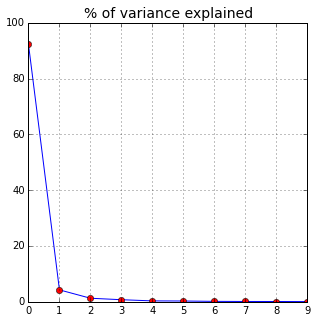

In [25]:
f, ax = plt.subplots(figsize=(5,5))
ax.plot(skpca.explained_variance_ratio_[0:10]*100)
ax.plot(skpca.explained_variance_ratio_[0:10]*100,'ro')
ax.set_title("% of variance explained", fontsize=14)
ax.grid()

####keep number of PC sufficient to explain 98 % of the original variance

In [26]:
skpca.explained_variance_ratio_[0:10]*100

array([  9.23457102e+01,   4.27431937e+00,   1.27595833e+00,
         7.46703096e-01,   3.27267614e-01,   2.83718481e-01,
         1.57156400e-01,   1.17552055e-01,   1.07471672e-01,
         7.43434722e-02])

**np.where( )**:

if only a condition parameter passed in, it returns a **tuple** 
see the [numpy doc](http://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html)

In the first cell of the tuple, an ndarray of indices where condition was met stored. 

The first of the array, is the first value meet the condition.

In [27]:
ipc = np.where(skpca.explained_variance_ratio_.cumsum() >= 0.98)[0][0]

In [28]:
ipc

3

Someone use this style:

    skpca.fit(X_st).transtorm(X_st)

see the [example of pca from scikit-learn](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)

In [29]:
PCs = skpca.transform(X_st)

In [30]:
PCs.shape

(252, 99)

In [31]:
PCs = PCs[:,:ipc]

In [32]:
EOFs = skpca.components_

In [33]:
EOFs.shape

(99, 99)

In [34]:
EOFs = EOFs[:ipc,:]

In [35]:
EOFs.shape

(3, 99)

In [36]:
EOF_recons = np.reshape(EOFs, (ipc, len(lat), len(lon)), order='F')

In [37]:
EOF_recons.shape

(3, 9, 11)

In [38]:
type(EOF_recons)

numpy.ndarray

In [39]:
EOF_recons.min()

-0.21608154210152439

In [40]:
EOF_recons *= 100

In [41]:
m = bm(projection='cyl',llcrnrlat=lat.min(),urcrnrlat=lat.max(),\
            llcrnrlon=lon.min(),urcrnrlon=lon.max(),\
            lat_ts=0,resolution='c')

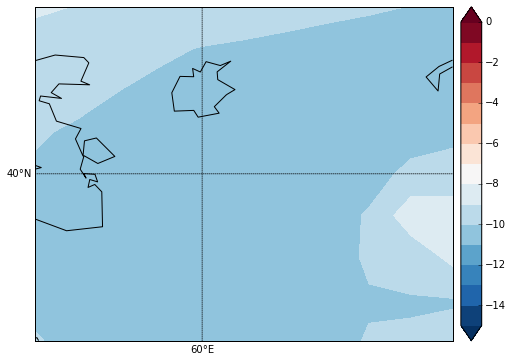

In [42]:
plot_field(m, EOF_recons[0,:,:], lats, lons, -15, 0, 1, grid=True, cmap=plt.get_cmap('RdBu_r'))

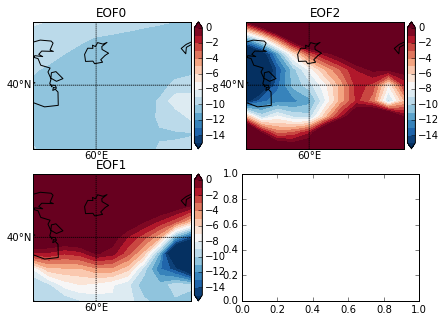

In [43]:
f, axes = plt.subplots(nrows=2,ncols=2, figsize=(7,5))
f.subplots_adjust(hspace=0.2, wspace=0.2)
axes = axes.flatten('F')
for i in [0,1,2]:
    plot_field(m, EOF_recons[i,:,:], lats, lons, -15, 0, 1, ax=axes[i], title='EOF'+str(i), grid=True, cmap=plt.get_cmap('RdBu_r'))

In [44]:
from sklearn.preprocessing import StandardScaler

In [45]:
scaler_PCs = StandardScaler()

In [46]:
scaler_PCs.fit(PCs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [47]:
PCs_std = scaler_PCs.transform(PCs)

In [48]:
PCdf = pd.DataFrame(PCs_std, index = dsub['time'], \
                    columns = ["EOF%s" % (x) for x in range(1, PCs_std.shape[1] +1)])

In [49]:
PCdf.head()

,EOF1,EOF2,EOF3
time,,,
1980-01-01,-1.167359,0.011618,0.211772
1980-02-01,-1.140762,1.843819,-0.073469
1980-03-01,-0.579187,1.628092,2.073873
1980-04-01,0.385705,-0.234115,2.438725
1980-05-01,0.673853,0.009316,-0.173958


In [50]:
from scipy.signal import detrend

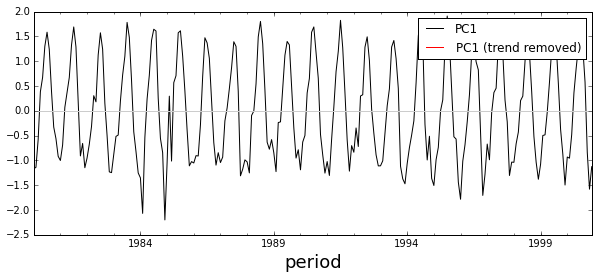

In [51]:
f, ax = plt.subplots(figsize=(10,4))
PCdf.ix[:,0].plot(ax=ax, color='k', label='PC1')
ax.axhline(0, c='0.8')
ax.set_xlabel('period', fontsize=18)
ax.plot(PCdf.index, detrend(PCdf.ix[:,0].values), 'r',  label='PC1 (trend removed)')
ax.grid('off')
ax.legend(loc=1); 
